# Introducción a las redes neuronales profundas
# Proyecto 2 

Clasificar los vectores x1 y x2 usando backpropagation en una red neuronal shallow, para ello usar los siguientes métodos:

1. Usando SDBP
2. Método de momento
3. Método de Levenberg-Marquardt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from network import network 
%matplotlib inline

In [2]:
x1 = np.array([[-4,-3],[-4,-1],[-3,-3],[-3,-1],[-3,0],[-2,-2],[0,-1],[1,-1],[1,0],[1,2],
               [2,-1],[2,1],[2,2],[2,3],[2,4],[3,-4],[3,-3],[3,-2],[3,-1],[4,-1]])

x2 = np.array([[-1,-4],[-1,-3],[-1,2],[-1,3],[-1,4],[0,-4],[0,-3],[0,2],[1,-5],[1,-4],
               [1,4],[3,2],[3,3],[4,1],[4,2]])

X = np.concatenate((x1, x2))
y = np.concatenate((np.zeros(20), np.ones(15)))

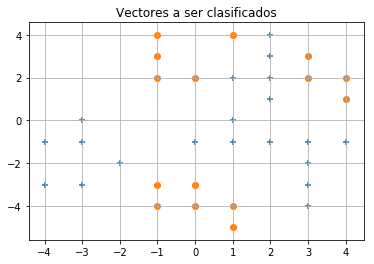

In [3]:
plt.scatter(x1[:,0], x1[:,1], marker='+')
plt.scatter(x2[:,0], x2[:,1], marker='o')
plt.title('Vectores a ser clasificados')
plt.grid(True)
plt.show()

In [4]:
X = np.concatenate((x1, x2))
y = np.concatenate((np.zeros(20), np.ones(15)))

### Arquitectura de la red neuronal

La red neuronal es de tres capas:
1. Activacion => tanh
2. Activacion => relu
3. Activacion => sigmoid

In [5]:
sigmoid = np.vectorize(lambda x: 1/(1+np.power(np.e, -x)))
dxsigmoid = np.vectorize(lambda x: sigmoid(x) * (1 - sigmoid(x)))

tanh = np.vectorize(lambda x: (np.e**x-np.e**(-x))/(np.e**x+np.e**(-x)))
dxtanh = np.vectorize(lambda x: 1 - np.square(tanh(x)))

relu = np.vectorize(lambda x: 0 if x<0 else x)
dxrelu = np.vectorize(lambda x: 0 if x<0 else 1)

threshold = np.vectorize(lambda x: 0 if x<0.5 else 1)

activations  = [tanh, relu, sigmoid]
derivatives  = [dxtanh, dxrelu, dxsigmoid]
#derivatives2 = [dx2tanh, dx2relu, dx2sigmoid]

In [7]:
# Crear una superficie en 2D para realizar las predicciones y 
# visualizar la frontera de desicion creada por la dnn
steps = 150
xx, yy = np.meshgrid(np.linspace(-8, 8, steps), np.linspace(-8, 8, steps))
xxyy = np.hstack((xx.reshape(steps*steps, 1), yy.reshape(steps*steps, 1)))

### Método SDBP

En el método de la retropropagación, el error de la capa de salida se propaga hacia atras hasta llegar a la última capa, para actualizar los pesos y los sesgos, reduciendo asi el error.

La actualización de los pesos se realiza en la direccion opuesta al máximo incremento, usando el gradiente descendiente de la función de error con respecto a los parametros.

La actualización de los parámetros de la red neuronal se realizan de la siguiente manera:

$$w_{t+1} = w_t - \nabla w_t$$
$$b_{t+1} = b_t - \nabla w_t $$

$$\nabla w_t = -\epsilon \nabla_w E(w_t)$$


In [8]:
net1 = network([2, 100, 100, 1], activations, derivatives)

In [9]:
_error, _epochs = net1.fit(X, y, epochs=100, learning_rate=0.005, method='SGD')
print('Accuracy => %.2f' % net1.score(X, y))

100%|██████████| 100/100 [00:07<00:00, 12.54it/s]

Accuracy => 100.00


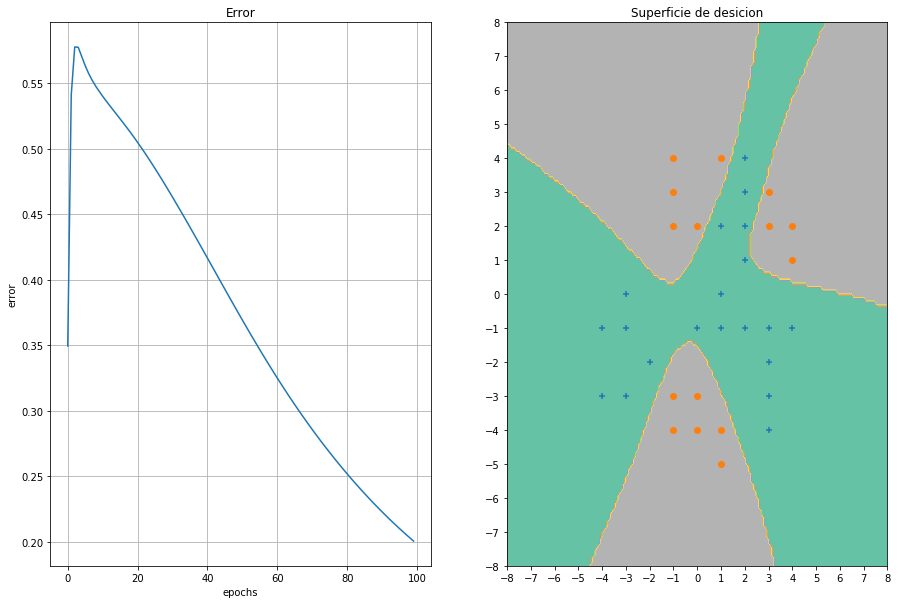

In [10]:
grid_prediction1 = threshold(net1.predict(xxyy)) 
grid_prediction1.shape = (steps, steps)

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.plot(_epochs, np.abs(_error))
plt.grid(True)
plt.title('Error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.subplot(122)
plt.contourf(xx, yy, grid_prediction1, cmap='Set2')
plt.scatter(x1[:,0], x1[:,1], marker='+')
plt.scatter(x2[:,0], x2[:,1], marker='o')
plt.xticks(range(-8, 9))
plt.yticks(range(-8, 9))
plt.title('Superficie de desicion')
plt.show()

### Método de momento

El parmetro del momento en las ecuaciones de la retropopagación es análogo a la masa de las particulas Newtonianas, que se mueven a traves de un medio viscoso en un campo de fuerza conservativo. El comportamiento del sistema cerca de un mínimo local es equivalente a un conjunto de osciladores armonicos amortiguados. Incluir el parámetro del momento mejora la velocidad de convergencia

La siguiente ecuación indica como se actualizan los parámetros de la red:

$$\nabla w_t = -\epsilon \nabla_w E(w_t) + p\nabla_{w_{t-1}} $$

La modificación del vector de pesos en un instante de tiempo dado depende del gradiente de la función de error en el instante presente y del cambio del vector de pesos en el instante anterior.

In [11]:
net2 = network([2, 100, 100, 1], activations, derivatives)

In [12]:
_error, _epochs = net2.fit(X, y, epochs=100, learning_rate=0.005, method='momentum', beta=0.9)

100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


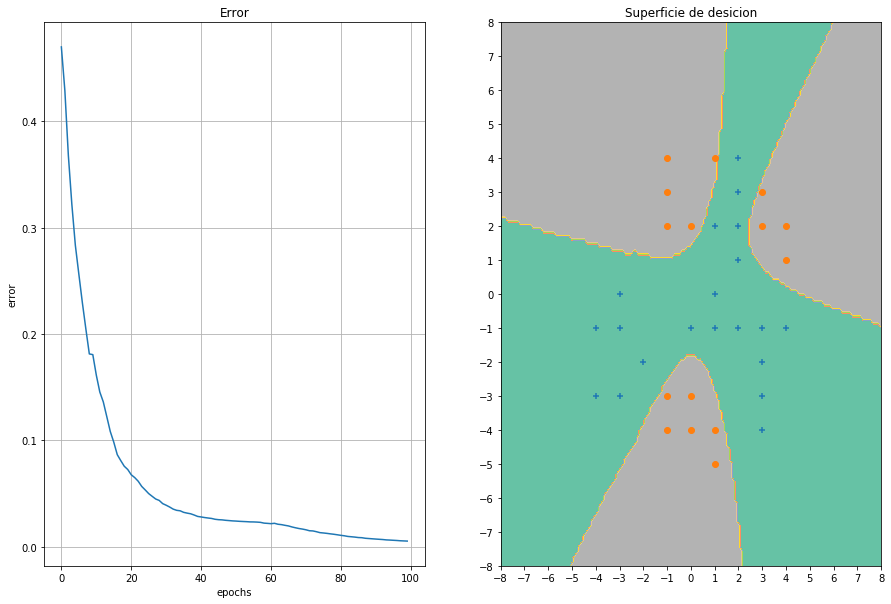

In [13]:
grid_prediction2 = threshold(net2.predict(xxyy)) 
grid_prediction2.shape = (steps, steps)

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.plot(_epochs, np.abs(_error))
plt.grid(True)
plt.title('Error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.subplot(122)
plt.contourf(xx, yy, grid_prediction2, cmap='Set2')
plt.scatter(x1[:,0], x1[:,1], marker='+')
plt.scatter(x2[:,0], x2[:,1], marker='o')
plt.xticks(range(-8, 9))
plt.yticks(range(-8, 9))
plt.title('Superficie de desicion')
plt.show()

### Método de Levenberg-Marquardt

El algoritmo de Levenberg-Marquardt puede ser visto como una regularizacion del metodo de Gauss-Newton, donde un parametro de regularizacion es actualizado en cada iteracion, controlando indirectamente el tamaño del paso, haciendo asi que converga globalmente independientemente del punto de inicio.

La ventaja de usar la matriz Hessiana es que proporciona informacion sobre la curvatura de la funcion de error a minimizar.

$$\nabla w_{t+1} = -(H+\lambda diag[H])^{-1} \nabla E(w_t)$$

$$H(x) = \nabla^2f(x) = J(x)^TJ(x)$$

### Referencias

1. Qian, Ning, On the momentum term in gradient descent learning algorithms: [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.57.5612&rep=rep1&type=pdf]
2. Ranganatha, Ananth, The Levenberg-Marquardt algorithm: [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.10.2258&rep=rep1&type=pdf]